In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pylab import *
import json
import cv2
import h5py
import imageio
from IPython.display import Image

import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    MaxPooling2D,
    UpSampling2D,
    concatenate
)
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#from tensorflow.compat.v1.logging import INFO, set_verbosity

#set_verbosity(INFO)

K.set_image_data_format("channels_first")

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Num GPUs Available:  1
Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pwd

'/Volumes/MX500_1TB/GitHub/Projects/TEM_seg'

In [3]:
# set home directory and data directory
HOME_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/"
IMG_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/img/"
MSK_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/msk/"

#Data Augmentation Path
AUG_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/aug/"

SUB_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/sub_img/"
TRAIN_DATA_DIR = ""
VALID_DATA_DIR = ""
TEST_DATA_DIR = ""

# Encoder(DownSampling) Block

In [4]:
def conv_block(inputs = None, n_filters = 32, dropout_prob = 0, max_pooling = True):


  """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
  """

  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation = 'relu',
                padding = 'same',
                kernel_initializer = 'he_normal')(inputs)

  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation = 'relu',
                padding = 'same',
                kernel_initializer = 'he_normal')(conv)

  # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
  if max_pooling:
    next_layer = MaxPooling2D(2, strides = 2)(conv)

  else:
    next_layer = conv

  skip_connection = conv

  return next_layer, skip_connection


# Decoder(UpSampling) Block

In [5]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
  """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
  """

    ### START CODE HERE
  up = Conv2DTranspose(filters = n_filters,
                       kernel_size = 3,
                       strides=2,
                       padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
  #merge = concatenate([up, contractive_input], axis=3)
  merge = concatenate([up, contractive_input], axis=1)
  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(merge)
  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)

  return conv

# UNET Model

In [6]:

def unet_model(input_size=(256, 256, 1), n_filters=32, n_classes=1):
    """ 
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    #conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    conv10 = Conv2D(filters = 1, kernel_size = 1, data_format = 'channels_first',activation='sigmoid')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [7]:
unet= unet_model(input_size=(1,256, 256), n_filters=32, n_classes=1)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-01-20 14:24:48.751776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-20 14:24:48.751974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 256, 256  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 256, 256  9248        ['conv2d[0][0]']                 
                                )                                                             

In [9]:
unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['BinaryIoU'])

In [10]:
class Img_DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                sample_list,
                 base_dir,
                 batch_size=8,
                 #batch_size=1,
                 shuffle=True,
                 dim=(256, 256),
                 num_channels=1,
                 num_classes=1,
                 verbose=1):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.dim = dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.sample_list = sample_list
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_list) / self.batch_size))
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size, self.num_channels, *self.dim),
                     dtype=np.float32) #np.float64
        y = np.zeros((self.batch_size, self.num_classes, *self.dim),
                     dtype=np.float32) #np.float64
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.verbose == 1:
                print("Training on: %s" % self.base_dir + ID)
            with h5py.File(self.base_dir + ID, 'r') as f:
                a = np.array(f.get("x"))
                X[i]=scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape)
                y[i] = np.array(f.get("y"))
        return X, y
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        sample_list_temp = [self.sample_list[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(sample_list_temp)

        return X, y


In [11]:
# Get generators for training and validation sets
batch_size = 8
base_dir = HOME_DIR
#base_dir = "./BraTS-Data/processed/"
#with open(base_dir + "config.json") as json_file:
with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)

print(len(config["train"]))

train_generator = Img_DataGenerator(config["train"], base_dir + "sub_img/", batch_size=batch_size, dim=(256, 256), verbose=1)


784


In [12]:
num_channels = 1
num_classes = 1
dim = (256, 256)
X_series = np.zeros((len(config["train"]), num_channels, *dim),
             dtype=np.float64) #float64
y_series = np.zeros((len(config["train"]), num_classes, *dim),
             dtype=np.float64) #float64
# Generate data

#base_dir = "./BraTS-Data/processed/"
directory_train = base_dir + "sub_img/"
print(directory_train)


for i,ID in enumerate(config["train"]):
    # Store sample
    print(ID)
    with h5py.File(directory_train + ID, 'r') as f:
        X_series[i] = np.array(f.get("x"))
        y_series[i] = np.array(f.get("y"))


print(X_series.shape)
print(y_series.shape)

/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/sub_img/
X2248-60000X-2.tif_x_384_y_768_.h5
E1-60000X-1.tif_x_256_y_512_.h5
E1-60000X-38.tif_x_512_y_640_.h5
E1-60000X-2.tif_x_768_y_128_.h5
X2248-60000X-5.tif_x_256_y_384_.h5
E1-60000X-4.tif_x_384_y_512_.h5
E1-60000X-58.tif_x_128_y_128_.h5
E1-60000X-1.tif_x_640_y_512_.h5
X2248-60000X-5.tif_x_640_y_0_.h5
X2248-60000X-5.tif_x_640_y_384_.h5
E1-60000X-58.tif_x_768_y_0_.h5
E1-60000X-16.tif_x_768_y_0_.h5
E1-60000X-2.tif_x_640_y_128_.h5
E1-60000X-7.tif_x_384_y_128_.h5
E1-60000X-5.tif_x_128_y_640_.h5
E1-60000X-3.tif_x_512_y_256_.h5
E1-60000X-3.tif_x_640_y_0_.h5
E1-60000X-2.tif_x_256_y_128_.h5
X2248-60000X-5.tif_x_768_y_384_.h5
E1-60000X-58.tif_x_512_y_512_.h5
E1-60000X-6.tif_x_512_y_640_.h5
E1-60000X-1.tif_x_768_y_512_.h5
X2248-60000X-1.tif_x_384_y_384_.h5
X2248-60000X-1.tif_x_0_y_384_.h5
X2248-60000X-2.tif_x_384_y_0_.h5
E1-60000X-38.tif_x_384_y_128_.h5
E1-60000X-5.tif_x_384_y_512_.h5
E1-60000X-59.tif_x_128_y_128_.h5
E1-60000X-37.tif_x_0_y_

In [13]:
X_train_1 = np.concatenate(X_series, axis = 0)
print(X_train_1.shape)

(784, 256, 256)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_series, y_series, test_size = 0.1, random_state =42)

In [15]:
steps_per_epoch = 93
n_epochs = 20

history = unet.fit(X_train,y_train,
        steps_per_epoch=steps_per_epoch,
        shuffle = True,
        epochs=n_epochs,
        use_multiprocessing=True,
        verbose=1
        #callbacks=[checkpoint]
        )


Epoch 1/20


2024-01-20 14:25:05.361519: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-20 14:25:06.154156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/93 [======>.......................] - ETA: 2:39 - loss: nan - binary_io_u: 0.3252

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split

def load_data(data_folder):
    file_paths = ...

    images = []
    labels = []

    for file_path in file_paths:
        with h5py.File(file_path, 'r') as file:
            x_data = np.array(file['x'])
            y_data = np.array(file['y'])
            images.append(x_data)
            labels.append(y_data)
    images = np.concatenate(images, axis = 0)
    labels = np.concatenate(labels, axis = 0)

    return images, labels

X, y = load_data('your_data_folder')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state =42)


In [14]:
steps_per_epoch = len(config["train"])/batch_size
n_epochs=20

history = unet.fit(X_train,y_train,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        use_multiprocessing=True,
        verbose=1
        #callbacks=[checkpoint]
        )

#history = model_3D.fit(x=train_generator,
#        steps_per_epoch=steps_per_epoch,
#        epochs=n_epochs,
#        class_weight =class_weights,
#        use_multiprocessing=True,
#        validation_data=valid_generator,
#        validation_steps=validation_steps,
#        verbose=1,
#        callbacks=[checkpoint]
#        )

#save the training results
#unet.save_weights(HOME_DIR + 'Seg_model_depth5_focal_100epochs.hdf5')

#Model.fit(
#    x=None,
#    y=None,
#    batch_size=None,
#    epochs=1,
#    verbose="auto",
#    callbacks=None,
#    validation_split=0.0,
#    validation_data=None,
#    shuffle=True,
#    class_weight=None,
#    sample_weight=None,
#    initial_epoch=0,
#    steps_per_epoch=None,
#    validation_steps=None,
#    validation_batch_size=None,
#    validation_freq=1,
#    max_queue_size=10,
#    workers=1,
#    use_multiprocessing=False,
#)


Epoch 1/20


2023-12-30 22:58:25.489999: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-30 22:58:26.370994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 81/392 [=====>........................] - ETA: 3:19 - loss: nan - binary_io_u: 0.3757

KeyboardInterrupt: 

In [ ]:
# Plot the training loss and accuracy
plt.plot(history.history['loss'])
#plt.plot(history.history['BinaryCrossentropy'])
plt.plot(history.history['BinaryIoU'])
#plt.plot(history.history['val_dice_coefficient'])

# Add labels and title
plt.title('Model Loss and BinaryIoU')
plt.xlabel('Epoch')
plt.ylabel('Loss / BinaryIoU')
#plt.legend(['Loss', 'Val_Loss', 'Dice Coefficient', 'Val_Dice Coefficient'], loc='center right')
plt.legend(['Loss', 'BinaryIoU'], loc='center right')

# Show the plot
plt.show()

In [90]:
HOME_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train"
IMG_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/img/"
MSK_DIR = "/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/data_train/msk/"

img=np.array(imageio.imread('/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/tif_image/E1-60000X-3.tif'))
img_scale=scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)

/var/folders/0p/s_v762_d0zbdf1spxr00w4gc0000gn/T/ipykernel_43484/1112838685.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=np.array(imageio.imread('/Volumes/MX500_1TB/DataSet/BF-TEM/CJL_lab/tif_image/E1-60000X-3.tif'))


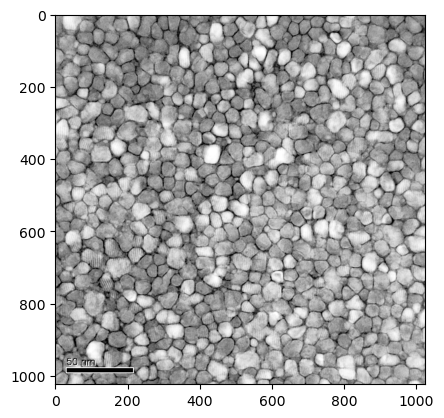

In [91]:
plt.imshow(img, cmap = 'Greys')

In [93]:
print(img_scale.shape)
print(np.max(img_scale))

(1024, 1024)
1.0


(256, 256)
1.0


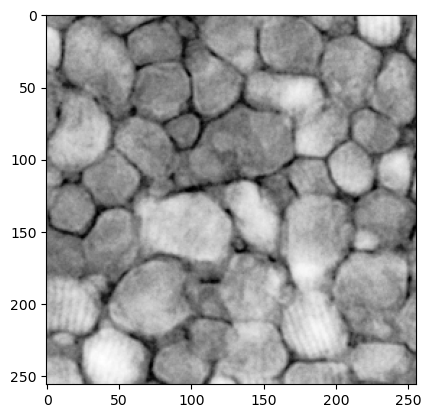

In [96]:
start_x = 128
start_y = 128

output_x = 256
output_y = 256

img_part = np.copy(img_scale[start_x: start_x + output_x, start_y: start_y + output_y])

print(img_part.shape)
print(np.max(img_part))
plt.imshow(img_part, cmap = 'Greys')

In [103]:
X = np.expand_dims(img_part, axis=0)
X = np.expand_dims(X, axis=0)

print(X.shape)


(1, 1, 256, 256)


1/1 [==============================] - 0s 193ms/step


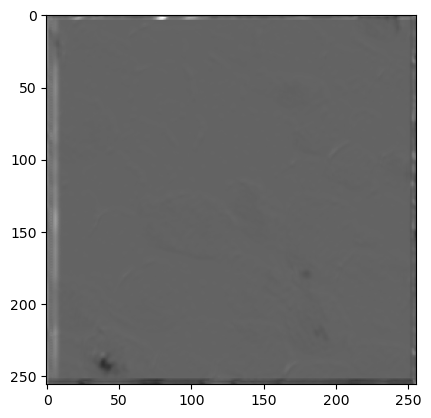

In [105]:
pred_mask = unet.predict(X)
plt.imshow(pred_mask[0,0,:,:], cmap = 'Greys')


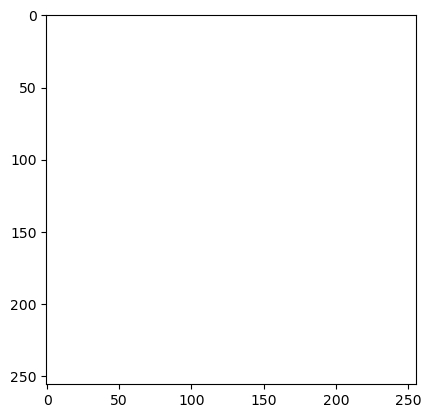

In [113]:
pred_msk = pred_mask[0,0,:,:]
thres=0.1
pred_msk[pred_msk >= thres] = 1
pred_msk[pred_msk < thres] = 0

plt.imshow(pred_msk, cmap = 'Greys')

In [115]:
pred_mask = unet.predict(X)

1/1 [==============================] - 0s 295ms/step


In [116]:
print(pred_mask[0,0,0,:])

[0.8379675  0.84487545 0.8493034  0.8614002  0.8693368  0.8718925
 0.8695255  0.8723347  0.8765775  0.88122    0.88473773 0.8871685
 0.88693124 0.8852708  0.8854787  0.8903863  0.899366   0.91075844
 0.92040765 0.9291223  0.9343953  0.9352696  0.9317505  0.9258214
 0.9177623  0.90673095 0.8950887  0.8875163  0.88733345 0.891877
 0.89782864 0.9043903  0.91010886 0.91377836 0.91297245 0.90716946
 0.8987683  0.89234    0.8900272  0.89189976 0.89390427 0.8926193
 0.8874605  0.8832268  0.8810532  0.8818899  0.8814023  0.8794081
 0.87629235 0.87465674 0.8753979  0.8766547  0.8768969  0.8749798
 0.8720937  0.86998767 0.869323   0.8683254  0.86705804 0.86507
 0.86447173 0.86558336 0.86690843 0.86749846 0.86736244 0.86755484
 0.8696631  0.8742543  0.87911004 0.8816945  0.88243455 0.88404113
 0.88912755 0.89793795 0.90870476 0.919455   0.93066144 0.941292
 0.95008314 0.9554618  0.95529467 0.9480041  0.9340045  0.91739804
 0.90464544 0.8997516  0.8990863  0.8999792  0.90043664 0.900019
 0.9011947

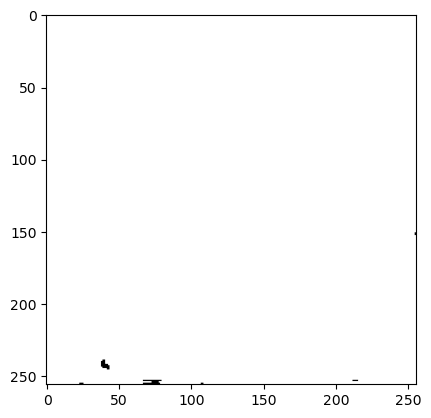

In [122]:
pred_msk = pred_mask[0,0,:,:]

pred_thres=np.zeros(pred_msk.shape)
thres=0.5
pred_thres[pred_msk >= thres] = 1.0
pred_thres[pred_msk < thres] = 0.0

plt.imshow(pred_thres, cmap = 'Greys')